# Project 1: Digit Classification with KNN and Naive Bayes

In this project, you'll implement your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but <b> please prepare your own write-up (with your own code). </b>

If you're interested, check out these links related to digit recognition:

Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/

Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

In [761]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

Load the data. Notice that we are splitting the data into training, development, and test. We also have a small subset of the training data called mini_train_data and mini_train_labels that you should use in all the experiments below, unless otherwise noted.

In [762]:
# Load the digit data either from mldata.org, or once downloaded to data_home, from disk. The data is about 53MB so this cell
# should take a while the first time your run it.
mnist = fetch_mldata('MNIST original', data_home='~/datasets/mnist')
X, Y = mnist.data, mnist.target

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print ('data shape: ', X.shape)
print ('label shape:', Y.shape)

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]


data shape:  (70000, 784)
label shape: (70000,)


(1) Create a 10x10 grid to visualize 10 examples of each digit. Python hints:

- plt.rc() for setting the colormap, for example to black and white
- plt.subplot() for creating subplots
- plt.imshow() for rendering a matrix
- np.array.reshape() for reshaping a 1D feature vector into a 2D matrix (for rendering)

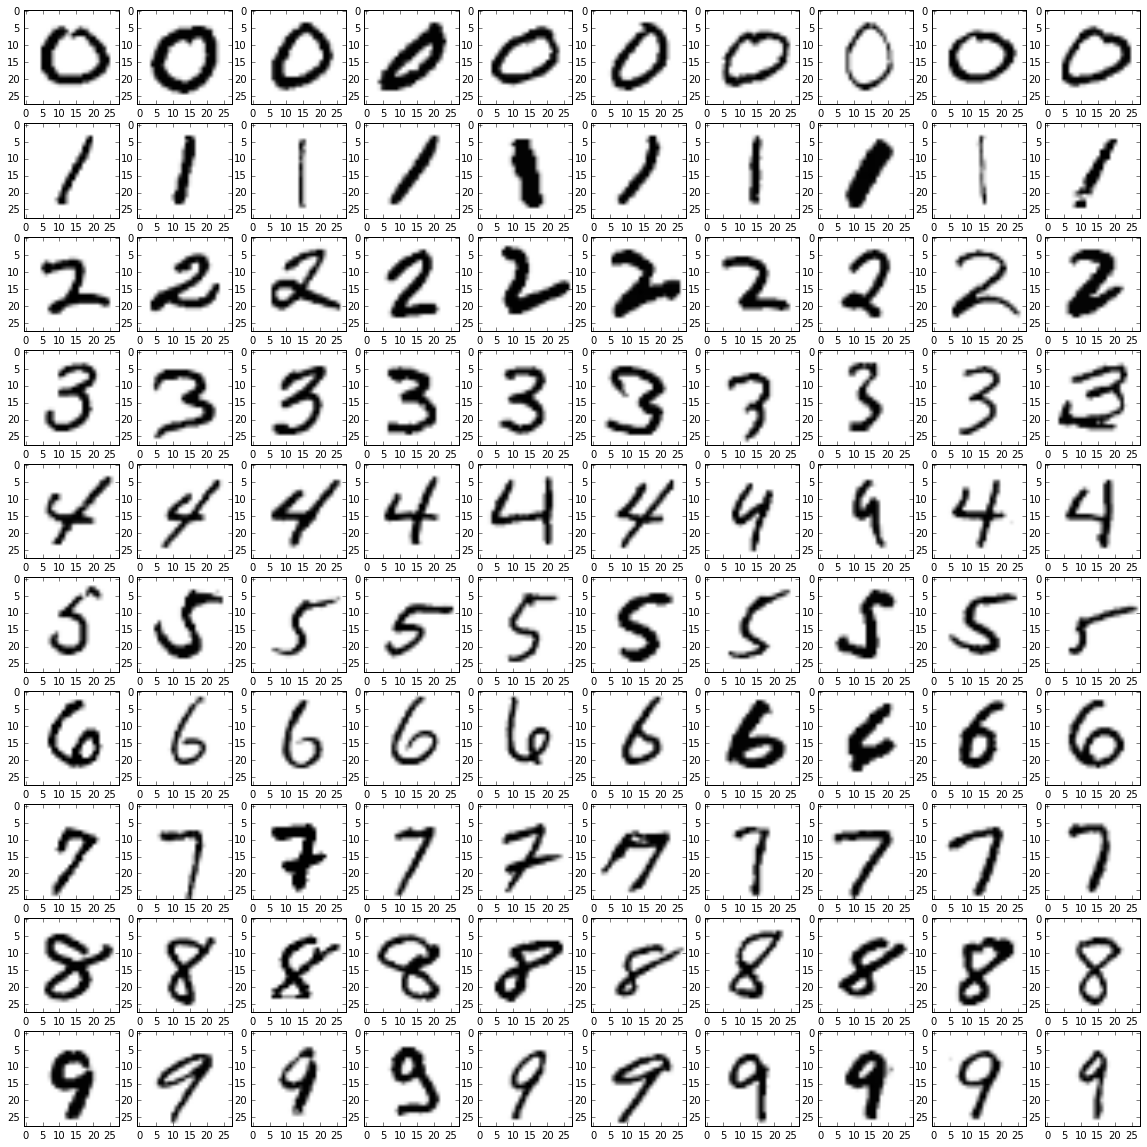

In [763]:
def P1(Y, X, num_examples=10):
    #set the figure size
    plt.figure(figsize=(20,20))
    
    for i in range (10):
        count=0
        #As i go from the digit 0-9, we search through Labels and save the index of the first 10 samples matching the digit of interest
        temp=np.where(Y == i)[0][0:num_examples]
        
        #we loop through the index to pick out the training data that correspond to the digit of interest
        for j in temp:
            count+=1
            #transform the 784 features into a 28 by 28 table and then plot
            grid = np.reshape(X[j],(28,28))
            plt.subplot(10, 10, i*10+count)
            img = plt.imshow(grid, cmap = 'Greys')
    
    plt.show()

P1(Y, X, 10)

(2) Evaluate a K-Nearest-Neighbors model with k = [1,3,5,7,9] using the mini training set. Report accuracy on the dev set. For k=1, show precision, recall, and F1 for each label. Which is the most difficult digit?

- KNeighborsClassifier() for fitting and predicting
- classification_report() for producing precision, recall, F1 results

In [764]:
def P2(i, mini_train_data, mini_train_labels):
    #fit the mini training data against KNeighbors Classifier with k=i
    kn=KNeighborsClassifier(n_neighbors=i)
    kn.fit(mini_train_data, mini_train_labels)    
    return kn
                               
k_values = [1, 3, 5, 7, 9]
#loop through k_values and train each model accordingly and output the accuracy
for i in k_values:
    kn= P2(i, mini_train_data, mini_train_labels)
    print ('Accuracy of K-Neighbors Classifier with k =', i, 'is', kn.score(dev_data, dev_labels))

#Refit with K=1 to output the classification report
kn=P2(1, mini_train_data, mini_train_labels)
print ('')
print ('For k = 1, this is the classification reprot')
print (classification_report(dev_labels, kn.predict(dev_data), target_names=np.unique(dev_labels).astype(int).astype(str)))

Accuracy of K-Neighbors Classifier with k = 1 is 0.888
Accuracy of K-Neighbors Classifier with k = 3 is 0.878
Accuracy of K-Neighbors Classifier with k = 5 is 0.869
Accuracy of K-Neighbors Classifier with k = 7 is 0.865
Accuracy of K-Neighbors Classifier with k = 9 is 0.863

For k = 1, this is the classification reprot
             precision    recall  f1-score   support

          0       0.91      0.98      0.94        99
          1       0.89      1.00      0.94       105
          2       0.99      0.79      0.88       102
          3       0.77      0.87      0.82        86
          4       0.89      0.82      0.85       104
          5       0.93      0.84      0.88        91
          6       0.94      0.96      0.95        98
          7       0.89      0.92      0.90       113
          8       0.94      0.88      0.91        96
          9       0.78      0.82      0.80       106

avg / total       0.89      0.89      0.89      1000



ANSWER: 
3 and 9 are both difficult digits.
9 score a little better in percision, but a lot worse in recall. The overall F1 score is also lower with the digit 9, so overall speaking 9 would be the most difficult digit.

(3) Using k=1, report dev set accuracy for the training set sizes below. Also, measure the amount of time needed for prediction with each training size.

- time.time() gives a wall clock value you can use for timing operations

In [765]:
def P3(train_sizes, accuracies, X,Y,dev_data,dev_labels):
    for i in range (len(train_sizes)):
        #Create a new mini train set base training set size
        new_mini_train_data, new_mini_train_labels = X[:train_sizes[i]], Y[:train_sizes[i]]
        #Call function P2 to train the model with new mini train set using KNeighbors Classifier with k=1
        kn= P2 (1,new_mini_train_data, new_mini_train_labels)
        accuracy = round(kn.score(dev_data, dev_labels),2)
        #Measure the time needed for prediction 
        start = time.time()
        kn.predict(dev_data)
        elapsed = round((time.time() - start),2)
        #Add this to the accuracies variable and return it at the end
        accuracies =np.append(accuracies, accuracy)
        print('For training set size of', train_sizes[i], 'the accuracy is', accuracy, 'and time to predict is',elapsed,'seconds')
    return accuracies

train_sizes = np.array((100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000))
accuracies = np.array(())
accuracies = P3(train_sizes, accuracies,X,Y,dev_data,dev_labels)


For training set size of 100 the accuracy is 0.72 and time to predict is 0.12 seconds
For training set size of 200 the accuracy is 0.79 and time to predict is 0.25 seconds
For training set size of 400 the accuracy is 0.84 and time to predict is 0.49 seconds
For training set size of 800 the accuracy is 0.88 and time to predict is 0.97 seconds
For training set size of 1600 the accuracy is 0.9 and time to predict is 2.0 seconds
For training set size of 3200 the accuracy is 0.93 and time to predict is 4.02 seconds
For training set size of 6400 the accuracy is 0.94 and time to predict is 7.91 seconds
For training set size of 12800 the accuracy is 0.96 and time to predict is 16.19 seconds
For training set size of 25000 the accuracy is 0.97 and time to predict is 31.15 seconds


(4) Fit a regression model that predicts accuracy from training size. What does it predict for n=60000? What's wrong with using regression here? Can you apply a transformation that makes the predictions more reasonable?

- Remember that the sklearn fit() functions take an input matrix X and output vector Y. So each input example in X is a vector, even if it contains only a single value.

Estimated function: y = 0.000007x + 0.844
When training set = 60,000, the accuracy is expected to be 1.24467118315
Estimated function: y = 0.042439log(x) + 0.568
When training set = 60,000, the accuracy is expected to be 1.03503561795


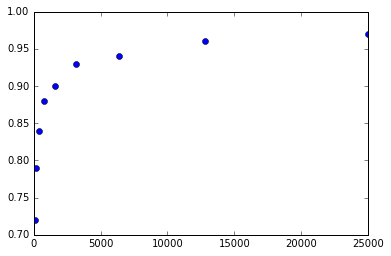

In [766]:
def P4(Xvar,Yvar):
    #Turn X into a matrix
    Xvar = Xvar[:, np.newaxis]
    #Fit the two variable using linear regression
    lr = LinearRegression(fit_intercept=True)
    lr.fit(Xvar, Yvar)
    return lr.coef_[0], lr.intercept_


#Fit the model using training set size variable and accuracies variable
m, b = P4(train_sizes,accuracies)
print ('Estimated function: y = %.6fx + %.3f' % (m,b))

#using the coefficient and intercept to predict the accuracy when n =60,000
print('When training set = 60,000, the accuracy is expected to be', m*(60000)+b)
plt.plot(train_sizes,accuracies,'o')


#Refit the model using log transformation on training set size variable
m2, b2 = P4(np.log(train_sizes),accuracies)
print ('Estimated function: y = %.6flog(x) + %.3f' % (m2,b2))

#using the new coefficient and intercept to predict the accuracy when n =60,000
print('When training set = 60,000, the accuracy is expected to be', m2*(np.log(60000))+b2)



ANSWER: When n = 60,0000, the regression model predicted the accuracy will be 124.5%. The problem with the model here is that the marginal contribution of each additional example becomes smaller as N increases. By using a log transformation on N, we are able to correct that problem. Using log(N) as the independent variable in the regression model, we can significantly reduce the impact. The new model predicts the accuracy to be 104%, which is more reasonable even if it still goes above 100%. 

Fit a 1-NN and output a confusion matrix for the dev data. Use the confusion matrix to identify the most confused pair of digits, and display a few example mistakes.

- confusion_matrix() produces a confusion matrix

[[ 97   0   0   0   0   0   2   0   0   0]
 [  0 105   0   0   0   0   0   0   0   0]
 [  4   4  81   4   0   0   0   4   3   2]
 [  1   0   0  75   0   3   0   3   1   3]
 [  0   2   0   0  85   0   3   0   0  14]
 [  2   0   0   9   0  76   0   1   1   2]
 [  1   1   1   0   1   0  94   0   0   0]
 [  1   4   0   1   1   0   0 104   0   2]
 [  0   2   0   5   0   2   1   0  84   2]
 [  1   0   0   3   9   1   0   5   0  87]]

Examples where Label is 4 but model predicted 9


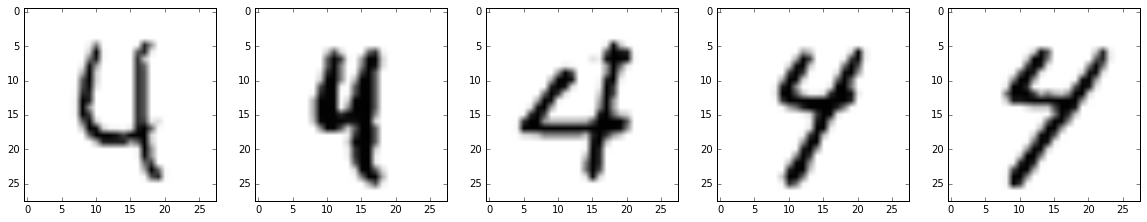

Examples where Label is 9 but model predicted 4


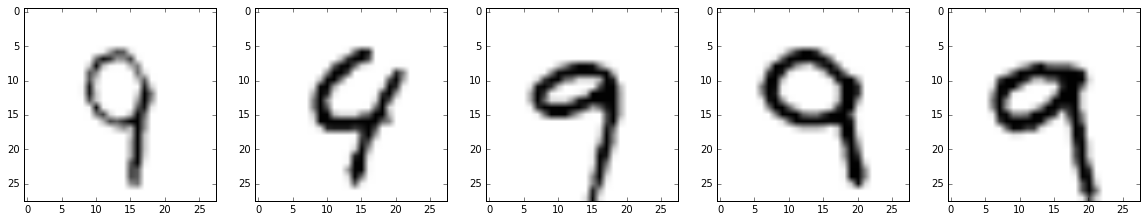

In [767]:
def P5(i, mini_train_data, mini_train_labels, dev_labels, dev_data):
    #Calls P2 Function to train the 1-NNmodel
    kn=P2(i,mini_train_data, mini_train_labels)
    #print the confusion_matrix to identify which two digits are most easily confused
    print(confusion_matrix(dev_labels, kn.predict(dev_data), labels=np.unique(dev_labels)))
    return kn
    
kn = P5(1, mini_train_data, mini_train_labels, dev_labels, dev_data)


#store the prediction in a new variable 
kn_confuse= kn.predict(dev_data)

#Display examples of the mistake
plt.figure(figsize=(20,20))
count = 0
#Find instances of label 4 but the prediction by the model is 9
for i in np.where(dev_labels == 4)[0]:
    if kn_confuse[i] ==9:
        count+=1
        #transform the 784 features into a 28 by 28 table and then plot
        grid = np.reshape(dev_data[i],(28,28))
        plt.subplot(1, 5, count)
        img = plt.imshow(grid, cmap = 'Greys')
    if count==5:
        break
print('')
print ('Examples where Label is 4 but model predicted 9')
plt.show()

#Find instances of label 9 but the prediction by the model is 4
plt.figure(figsize=(20,20))
count = 0 
for i in np.where(dev_labels == 9)[0]:
    if kn_confuse[i] ==4:
        count+=1
        #transform the 784 features into a 28 by 28 table and then plot
        grid = np.reshape(dev_data[i],(28,28))
        plt.subplot(1, 5, count)
        img = plt.imshow(grid, cmap = 'Greys')
    if count==5:
        break

print ('Examples where Label is 9 but model predicted 4')
plt.show()


ANSWER: The most often confused pair of digits are 4 and 9. In the dev data, there are Fourteen instances where the label is 4 but the model predicted 9. There are also Nine instances where the label is 9 but the model predicted 4.

(6) A common image processing technique is to smooth an image by blurring. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian -- that is, the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

Implement a simplified Gaussian blur by just using the 8 neighboring pixels: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values. Try applying your blur filter in 3 ways:
- preprocess the training data but not the dev data
- preprocess the dev data but not the training data
- preprocess both training and dev data

Note that there are Guassian blur filters available, for example in scipy.ndimage.filters. You're welcome to experiment with those, but you are likely to get the best results with the simplified version I described above.

In [768]:
def P6(x):
    ret_data =np.zeros((x.shape))
    for g in range(len(x)): 
        #store the 3x3 gaussian distribution as an array from left to right, from top to bottom. 5th item is the center pixel weight 
        distribution =np.array([16/209,26/209,16/209,26/209,41/209,26/209,16/209,26/209,16/209])
        #transform the 784 features into a 28 by 28 table and then plot
        grid = np.reshape(x[g],(28,28))
        newgrid=np.zeros((28,28))
        
        #skip the first and last row&column, go through each of the other feature and apply the gaussian distribution to calculate the weighted pixel value
        for i in range (26):
            for j in range (26):
                temp=np.concatenate((grid[j][i:i+3],grid[j+1][i:i+3],grid[j+2][i:i+3]))
                newgrid[j+1][i+1]= np.dot(temp,distribution)
        #reshape it back and store in the new array
        ret_data [g]= np.reshape(newgrid,(784))
    return ret_data
    
#Preprocess training data but not dev data    
new_train_data= P6(mini_train_data)
print('Preprocess the training data but not the dev data')
#Call P5 to train the model and to output the confusion matrix so it can be compared against each other
kn = P5(1, new_train_data, mini_train_labels, dev_labels, dev_data)
print('')
#output the classificatio report so it can be compared against each other
print (classification_report(dev_labels, kn.predict(dev_data), target_names=np.unique(dev_labels).astype(int).astype(str)))

#Preprocess dev data but not training data    
new_dev_data= P6(dev_data)
print('')
print('Preprocess the dev data but not the training data')
kn = P5(1, mini_train_data, mini_train_labels, dev_labels, new_dev_data)
print('')
print (classification_report(dev_labels, kn.predict(dev_data), target_names=np.unique(dev_labels).astype(int).astype(str)))

#Preprocess dev data and training data
print('')
print('Preprocess both training and dev data')
kn = P5(1, new_train_data, mini_train_labels, dev_labels, new_dev_data)
print('')
print (classification_report(dev_labels, kn.predict(dev_data), target_names=np.unique(dev_labels).astype(int).astype(str)))




Preprocess the training data but not the dev data
[[ 97   0   0   0   0   0   2   0   0   0]
 [  0 104   1   0   0   0   0   0   0   0]
 [  3   2  85   4   0   0   0   3   4   1]
 [  0   0   1  75   0   4   0   2   2   2]
 [  0   0   0   0  86   0   2   2   1  13]
 [  2   0   0   7   0  80   0   0   1   1]
 [  2   1   0   0   1   0  94   0   0   0]
 [  0   1   0   2   1   0   0 105   0   4]
 [  0   1   1   4   0   2   0   0  87   1]
 [  1   0   0   3   5   1   0   4   0  92]]

             precision    recall  f1-score   support

          0       0.92      0.98      0.95        99
          1       0.95      0.99      0.97       105
          2       0.97      0.83      0.89       102
          3       0.79      0.87      0.83        86
          4       0.92      0.83      0.87       104
          5       0.92      0.88      0.90        91
          6       0.96      0.96      0.96        98
          7       0.91      0.93      0.92       113
          8       0.92      0.91      0.

ANSWER: We see improvement in all three preprocessing methods. However, where we only preprocess the development data, the incremental improvement in F1 score over the normal model is minimal. Both the model where we preprocess the training data only and where we preprocess both the training data and development data yield simliiar strong improvements over the normal model.

(7) Fit a Naive Bayes classifier and report accuracy on the dev data. Remember that Naive Bayes estimates P(feature|label). While sklearn can handle real-valued features, let's start by mapping the pixel values to either 0 or 1. You can do this as a preprocessing step, or with the binarize argument. With binary-valued features, you can use BernoulliNB. Next try mapping the pixel values to 0, 1, or 2, representing white, grey, or black. This mapping requires MultinomialNB. Does the multi-class version improve the results? Why or why not?

sklearn accuracy: 0.80 for Normal Version
sklearn accuracy: 0.81 for BinomialNB
sklearn accuracy: 0.79 for MuiltnomialNB


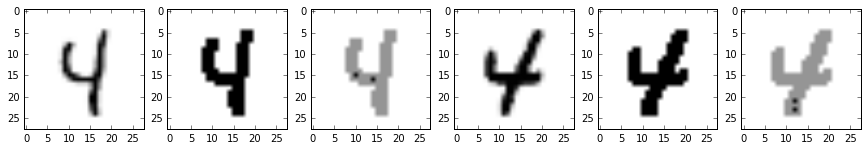

In [769]:
def P7(train_data, train_labels, alpha, nomial):
    #fit the model against bernoulliNB for binarized feature
    if nomial ==2:
        nb = BernoulliNB(alpha=alpha, fit_prior=False)
        nb.fit(train_data, train_labels)
        return nb
    #fit the model against multinomialNB for non - binarized feature
    else:
        nb = MultinomialNB(alpha=alpha, fit_prior=False)
        nb.fit(train_data, train_labels)
        return nb        

#Transform the features to 0,1 or to 0,1,2
def bi_multi_arize_pixel(data,nomial):
    if nomial ==2:
        # Initialize a new feature array with the same shape as the original data.
        binarized_data = np.zeros(data.shape)
        # Loop through and replace the value with 0,1 base on threshold
        for feature in range(data.shape[1]):
            binarized_data[:,feature] = data[:,feature] > 0
        return binarized_data
    else:
        # Initialize a new feature array with the same shape as the original data.
        multiarized_data = np.zeros(data.shape)
        # Loop through and replace the value with 0,1,2 base on threshold
        for feature in range(data.shape[1]):
            for i in range (data.shape[0]):
                if data[i,feature] <= 0:
                    multiarized_data[i,feature] = 0
                elif data[i,feature] >= 1:
                    multiarized_data[i,feature] = 2
                else:
                    multiarized_data[i,feature] = 1
        return multiarized_data       


# transform training and test data to 0,1
binarized_train_data = bi_multi_arize_pixel(mini_train_data,2)
binarized_dev_data = bi_multi_arize_pixel(dev_data,2)


# transform training and test data to 0,1,2
multiarized_train_data = bi_multi_arize_pixel(mini_train_data,3)
multiarized_dev_data = bi_multi_arize_pixel(dev_data,3)

#Compare the accuracy using (0,1) + BinomialNB vs (0,1,2)+ MultinomialNB
nb = P7(mini_train_data, mini_train_labels, alpha =1, nomial =3)
print ('sklearn accuracy: %3.2f for Normal Version' %nb.score(dev_data, dev_labels))
nb2 = P7(binarized_train_data, mini_train_labels, alpha =1, nomial =2)
print ('sklearn accuracy: %3.2f for BinomialNB' %nb2.score(binarized_dev_data, dev_labels))
nb3 = P7(multiarized_train_data, mini_train_labels, alpha =1, nomial = 3)
print ('sklearn accuracy: %3.2f for MuiltnomialNB' %nb3.score(multiarized_dev_data, dev_labels))

#show 2 examples of the label 4 and compare how the normal vs transformed imaged looks
plt.figure(figsize=(15,15))

grid = np.reshape(dev_data[0],(28,28))
plt.subplot(1, 6, 1)
img = plt.imshow(grid, cmap = 'Greys')
grid = np.reshape(binarized_dev_data[0],(28,28))
plt.subplot(1, 6, 2)
img = plt.imshow(grid, cmap = 'Greys')
grid = np.reshape(multiarized_dev_data[0],(28,28))
plt.subplot(1, 6, 3)
img = plt.imshow(grid, cmap = 'Greys')
grid = np.reshape(dev_data[7],(28,28))
plt.subplot(1, 6, 4)
img = plt.imshow(grid, cmap = 'Greys')
grid = np.reshape(binarized_dev_data[7],(28,28))
plt.subplot(1, 6, 5)
img = plt.imshow(grid, cmap = 'Greys')
grid = np.reshape(multiarized_dev_data[7],(28,28))
plt.subplot(1, 6, 6)
img = plt.imshow(grid, cmap = 'Greys')
plt.show()



ANSWER: The multinomialNB does not improve the results. We display the images from left to right (Normal, Binonmial, Multinomial) here. When we binarized the features, it makes its edge more solid and thus improving the recognition accuracy. However when we transform to (0,1,2), the image to image location of black (=2) varies drastically. This is one reason why the train model is less accurate than the normal version.

(8) Use GridSearchCV to perform a search over values of alpha (the Laplace smoothing parameter) in a Bernoulli NB model. What is the best value for alpha? What is the accuracy when alpha=0? Is this what you'd expect?

- Note that GridSearchCV partitions the training data so the results will be a bit different than if you used the dev data for evaluation.

In [770]:
def P8(alphas, train_data, train_labels):
    #use GridSearchCV to put the range for alpha into the model for fitting
    nb = GridSearchCV(BernoulliNB(), alphas)
    nb.fit(train_data, train_labels)
    return nb

alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
nb = P8(alphas, binarized_train_data, mini_train_labels)

print('The best value for alpha is %3.1f' %list(nb.best_params_.values())[0])
print ('sklearn accuracy: %3.2f for BernoulliNB' %nb.score(binarized_dev_data, dev_labels))

The best value for alpha is 0.1
sklearn accuracy: 0.82 for BernoulliNB


ANSWER: The best value of alpha is 0.1. If alpha =0, it will reduce the accuracy significantly (accurancy =0.1). This is as expected because with 784 features for each data point, there will be lots of cases where count (X,Y) is zero in the training data. Even a small number of alpha helps gernalize the model to larger dev set.

(9) Try training a model using GuassianNB, which is intended for real-valued features, and evaluate on the dev data. You'll notice that it doesn't work so well. Try to diagnose the problem. You should be able to find a simple fix that returns the accuracy to around the same rate as BernoulliNB. Explain your solution.

Hint: examine the parameters estimated by the fit() method, theta\_ and sigma\_.

In [771]:
def P9(train_data, train_labels):
    #training the model with gaussianNB
    gnb = GaussianNB()
    gnb.fit(train_data, train_labels)
    return gnb

# transform the train_data to make its distribution more normal by adding some randomly generated noise
def transforming (train_data):
    temp_train_data = np.zeros(train_data.shape)
    for i in range(temp_train_data.shape[0]):
        for j in range(temp_train_data.shape[1]):
            temp_train_data[i][j]= train_data [i][j]+np.random.rand() 
    return temp_train_data

#transform both the train_data and dev_data
gnb_train_data=transforming(mini_train_data)
gnb_dev_data=transforming(dev_data)
gnb = P9(gnb_train_data, mini_train_labels)
print ('sklearn accuracy: %3.2f for GuassianNB' %gnb.score(gnb_dev_data, dev_labels))

sklearn accuracy: 0.81 for GuassianNB


ANSWER: GaussianNB requires the data to have a normal distribution but the current test data does not. One way to resolve this is by adding random noise into the data.

(10) Because Naive Bayes is a generative model, we can use the trained model to generate digits. Train a BernoulliNB model and then generate a 10x20 grid with 20 examples of each digit. Because you're using a Bernoulli model, each pixel output will be either 0 or 1. How do the generated digits compare to the training digits?

- You can use np.random.rand() to generate random numbers from a uniform distribution
- The estimated probability of each pixel is stored in feature\_log\_prob\_. You'll need to use np.exp() to convert a log probability back to a probability.

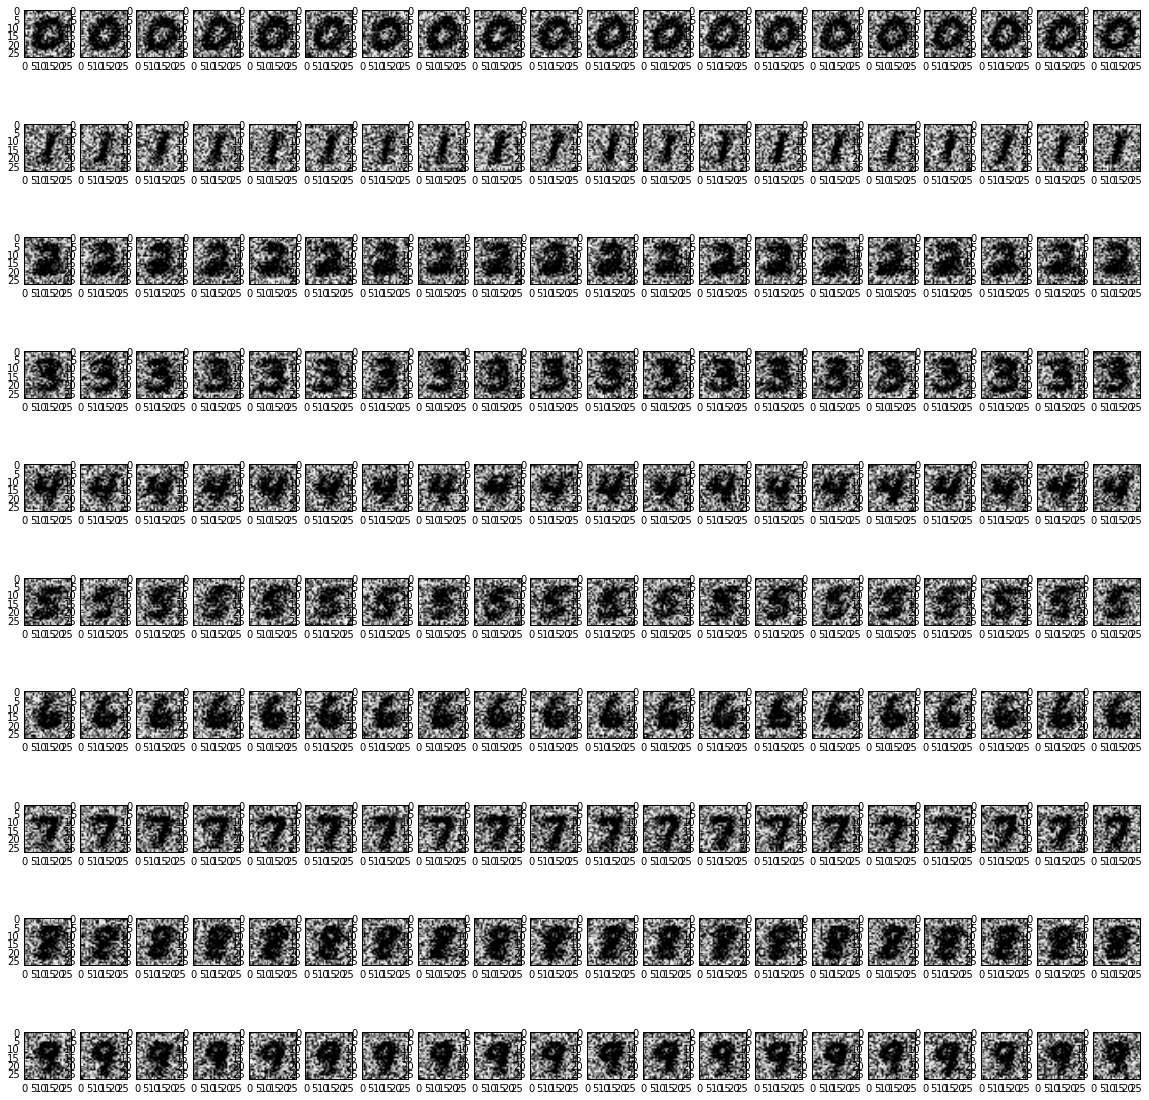

In [773]:
def P10(num_examples, mini_train_data,mini_train_labels):
    #Set the figure size
    plt.figure(figsize=(20,20))
    
    #Binarized the training data and then train the model
    binarized_train_data = bi_multi_arize_pixel(mini_train_data,2)

    nb = P7(binarized_train_data, mini_train_labels, alpha =1, nomial =2)
    
    #Save the feature probability for each label option into a new array
    threshold = np.exp(nb.feature_log_prob_)

    for i in range (threshold.shape[0]):
        count=0
        for j in range (num_examples):
            #Generate 784 random feature value through a uniform distribution
            temp_digit=np.random.rand(threshold.shape[1])
            #loop through each random feature value and if it is lower than the threshold, change it from 0 to a 1
            for k in range(threshold.shape[1]):
                if temp_digit[k]<threshold[i][k]:
                    temp_digit[k]=1
            count+=1
            #transform the 784 features into a 28 by 28 table and then plot
            grid = np.reshape(temp_digit,(28,28))
            plt.subplot(10, 20, i*20+count)
            img = plt.imshow(grid, cmap = 'Greys')
    plt.show()

P10(20, mini_train_data,mini_train_labels)


ANSWER: The generated image looks a more blurry than the training data. Where the training image has areas of pure white pixel in the edge of the image, the generated image has some random black pixel in those same areas. This is caused by the random generated digits which can sometimes go past the threshold in those white spaces.

(11) Remember that a strongly calibrated classifier is rougly 90% accurate when the posterior probability of the predicted class is 0.9. A weakly calibrated classifier is more accurate when the posterior is 90% than when it is 80%. A poorly calibrated classifier has no positive correlation between posterior and accuracy.

Train a BernoulliNB model with a reasonable alpha value. For each posterior bucket (think of a bin in a histogram), you want to estimate the classifier's accuracy. So for each prediction, find the bucket the maximum posterior belongs to and update the "correct" and "total" counters.

How would you characterize the calibration for the Naive Bayes model?

In [774]:
def P11(buckets, correct, total,  mini_train_data, dev_data, mini_train_labels, dev_labels):
    #Binarized the training data and dev data and then train the model
    binarized_train_data = bi_multi_arize_pixel(mini_train_data,2)
    binarized_dev_data = bi_multi_arize_pixel(dev_data,2)
    nb = P7(binarized_train_data, mini_train_labels, alpha =1, nomial =2)

    #Loop through each value in the bucket
    for i in range(len(buckets)):
        pred_data=[]
        #Loop through the dev_data and where the predict_prob of that sample is less than the bucket value, add that sample to new list
        for j in range (dev_data.shape[0]):
            if np.max(nb.predict_proba(dev_data[j])) <= buckets[i]:
                pred_data.append(j)
        #Loop through the new list and tally the correct vs total count        
        for k in pred_data:
            if nb.predict(dev_data[k]) == dev_labels[k]:
                correct[i]+=1
            total[i]+=1
    return correct, total

buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]

correct, total =P11(buckets, correct, total, mini_train_data, dev_data, mini_train_labels, dev_labels)

#Compute the accuracy and output the information
for i in range(len(buckets)):
    accuracy = 0.0
    if (total[i] > 0): accuracy = correct[i] / total[i]
    print ('p(pred) <= %.13f    total = %3d    accuracy = %.3f' %(buckets[i], total[i], accuracy))
    


p(pred) <= 0.5000000000000    total =   0    accuracy = 0.000
p(pred) <= 0.9000000000000    total =  28    accuracy = 0.571
p(pred) <= 0.9990000000000    total =  99    accuracy = 0.455
p(pred) <= 0.9999900000000    total = 158    accuracy = 0.475
p(pred) <= 0.9999999000000    total = 222    accuracy = 0.495
p(pred) <= 0.9999999990000    total = 276    accuracy = 0.525
p(pred) <= 0.9999999999900    total = 344    accuracy = 0.564
p(pred) <= 0.9999999999999    total = 400    accuracy = 0.605
p(pred) <= 1.0000000000000    total = 1000    accuracy = 0.814


ANSWER: The BernoulliNB model seems to be a weakly calibrated model. While there is a correlation between accuracy and posterior, the accuracy falls short of the posterior by a lot. 

(12) EXTRA CREDIT

Try designing extra features to see if you can improve the performance of Naive Bayes on the dev set. Here are a few ideas to get you started:
- Try summing the pixel values in each row and each column.
- Try counting the number of enclosed regions; 8 usually has 2 enclosed regions, 9 usually has 1, and 7 usually has 0.

Make sure you comment your code well!

In [777]:
def P12(x):
    #Create with 841 features because we plan to reshape to 29x29 and add row total and column total to it
    ret_data =np.zeros((1000,841))
    for g in range(len(x)):    
        #Reshape to 28x28
        grid = np.reshape(x[g],(28,28))
        newgrid=np.zeros((29,29))
        for i in range (28):
            for j in range (28):
                #Copy the values from the original dataset to the new dataset
                newgrid[i][j]=grid[i][j]
            #Add the row total to new dataset
            newgrid[i][28]= np.sum(grid[i])
            #Add the column total to new dataset
            newgrid[28][i]= np.sum(grid[:][i])
        #Add the grand total to new dataset
        newgrid[28][28] = np.average(grid)
        ret_data [g]= np.reshape(newgrid,(841))  
    return ret_data



#transform the training data and dev data
binarized_train_data = bi_multi_arize_pixel(mini_train_data,2)
binarized_dev_data = bi_multi_arize_pixel(dev_data,2)
sum_train_data = P12(binarized_train_data)
sum_dev_data = P12(binarized_dev_data)


#Train the model and compute the accuracy using the transformed data with BernoulliNB
nb = P7(sum_train_data, mini_train_labels, alpha =0.1, nomial = 2)
print ('sklearn accuracy: %3.2f for BernoulliNB' %nb.score(sum_dev_data, dev_labels))



sklearn accuracy: 0.83 for BernoulliNB


ANSWER: The new model has an accuracy of 0.83, which is higher than the 0.81/0.82 accuracy from the BernoulliNB model (alpha =1/alpha=0.1).